<h3>Import packages</h3>

In [1]:
from datetime import date
from timeit import default_timer as timer
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import imagenet_utils
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Configure TensorFlow to use GPU for training
tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
#Set GPU memory limit so my GPU doesn't crash
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


<h3>Create class to record time taken to train the model</h3>

In [3]:
#class to record time taken to train per epoch
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback()

<h3>Create train and test folder</h3>

In [4]:
#creates a folder each time the set of code is run to sort dataset into train and test
day = date.today()
formatDate = day.strftime("%b-%d-%Y")

#create folder with current date to group predictions ran in a day together, if it does not exists
if os.path.isdir('Prediction (' + formatDate + ')') is False:
    folder = os.mkdir('Prediction (' + formatDate + ')')
folder = 'Prediction (' + formatDate + ')'

#looping through to find if destination folder exists
i = 1
while True:
    if os.path.isdir(folder + '/Battery Images - ' + str(i)) is False:
        break
    i += 1

#destination path for unsorted folder
destination = folder + '/Battery Images - ' + str(i)

#source path for unsorted folder
# source = 'Battery Images/'
# source = 'Battery Images [Old]/'
# source = 'Battery Images [StreamLined]/'
source = 'Battery Images [Download]/'

#duplicate the unsorted folder from source to destination
shutil.copytree(source, destination)

os.mkdir(destination + '/train')
os.mkdir(destination + '/test')

<h3>Sort dataset into train and test folder</h3>

In [5]:
#function to split images into training (80%) and testing (20%) and return both
def split(data):
    # num = int(len(data) * 0.8)
    num = int(len(data) * 0.9) #90/10 split
#     num = int(len(data) * 0.7) #70/30 split
    random.shuffle(data)
    return data[:num], data[num:]

dir = os.chdir(destination)
for category in os.listdir(dir):
    #skip the iteration if folder is "train" or "test"
    skip = ['train', 'test']
    if category in skip:
        continue
    
    shutil.move(f'{category}', 'train')
    #create a subfolder with the same name in test
    os.mkdir(f'test/{category}')

    #get the images in each folder (battery type) for spltting of data into training and testing
    img = os.listdir(f'train/{category}')
    training, testing = split(img)
    
    for file in testing:
        shutil.move(f'train/{category}/{file}', f'test/{category}')

<h3>a) Simple sequential model</h3>

In [6]:
model = keras.Sequential()
model.add(keras.Input(shape=(224, 224, 3)))  # 250x250 RGB images
model.add(layers.Conv2D(32, 5, strides=2, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.GlobalMaxPooling2D())
# model.add(layers.Dense(5, activation="softmax"))
# model.add(layers.Dense(10, activation="softmax")) #For 10 Cats
model.add(layers.Dense(8, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                    

<h3>Process data</h3>

In [15]:
train_path = 'train'
test_path = 'test'

#for data augmentation on training data
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    # validation_split=0.2,
    validation_split=0.1, #changes made for 90/10 split
    rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
#     vertical_flip = False,    # randomly flip images
    vertical_flip = True, #include vertical flip for better generalisation
    )  

#takes images from directory path and generates batches of augmented data
train = datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=32,
    subset='training',
        shuffle = False)

#for validation data
# validation_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input, 
#                                         validation_split=0.2)
validation_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input, 
                                        validation_split=0.1) #changes made for 90/10 split


validation = validation_batches.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
        shuffle = False)

#for test data
test = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
.flow_from_directory(directory=test_path, target_size=(224,224), batch_size=32, shuffle=False)

Found 692 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
Found 89 images belonging to 8 classes.


<h3>Train model</h3>

In [19]:
# model.compile(optimizer=Adam(learning_rate=0.006), loss='categorical_crossentropy', metrics=['accuracy']) #Last best setting
# model.compile(optimizer=Adam(learning_rate=0.0045), loss='categorical_crossentropy', metrics=['accuracy']) #Lower LR
model.compile(optimizer=Adam(learning_rate=0.0075), loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint_filepath = './tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True) #save best model

es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)

#more epochs for better results
result = model.fit(x=train, validation_data=validation, epochs=300, verbose=2, callbacks=[model_checkpoint_callback, cb, es])
# result = model.fit(x=train, validation_data=validation, epochs=200, verbose=2, callbacks=[cb])
# 
# The model weights (that are considered the best) are loaded into the
# model.
result = model.load_weights(checkpoint_filepath)

Epoch 1/300
22/22 - 15s - loss: 2.0828 - accuracy: 0.1633 - val_loss: 2.0635 - val_accuracy: 0.1644 - 15s/epoch - 698ms/step
Epoch 2/300
22/22 - 15s - loss: 2.0693 - accuracy: 0.1633 - val_loss: 2.0620 - val_accuracy: 0.1644 - 15s/epoch - 683ms/step
Epoch 3/300
22/22 - 15s - loss: 2.0686 - accuracy: 0.1633 - val_loss: 2.0619 - val_accuracy: 0.1644 - 15s/epoch - 666ms/step
Epoch 4/300
22/22 - 15s - loss: 2.0710 - accuracy: 0.1633 - val_loss: 2.0613 - val_accuracy: 0.1644 - 15s/epoch - 662ms/step
Epoch 5/300
22/22 - 15s - loss: 2.0696 - accuracy: 0.1633 - val_loss: 2.0610 - val_accuracy: 0.1644 - 15s/epoch - 659ms/step
Epoch 6/300
22/22 - 15s - loss: 2.0679 - accuracy: 0.1633 - val_loss: 2.0612 - val_accuracy: 0.1644 - 15s/epoch - 688ms/step
Epoch 7/300
22/22 - 15s - loss: 2.0678 - accuracy: 0.1633 - val_loss: 2.0608 - val_accuracy: 0.1644 - 15s/epoch - 672ms/step
Epoch 8/300
22/22 - 15s - loss: 2.0682 - accuracy: 0.1633 - val_loss: 2.0608 - val_accuracy: 0.1644 - 15s/epoch - 675ms/step


<h3>Evaluate Test data</h3>

In [20]:
print(sum(cb.logs) / 150)

testLoss, testAcc = model.evaluate(test)
print('''
Test Loss: {}
Test Accuracy: {}
'''.format(testLoss, testAcc))

3.141054348666609
3/3 [==============================] - 1s 339ms/step - loss: 2.0707 - accuracy: 0.1573

Test Loss: 2.0707297325134277
Test Accuracy: 0.15730337798595428



<h4>*Optional - Fine tune model with two-step training*</h4>

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  
#re-train the model at a very low learning rate
model.compile(optimizer=Adam(learning_rate=0.00006), loss='categorical_crossentropy', metrics=['accuracy'])

result = model.fit(x=train, validation_data=validation, epochs=100, verbose=2, callbacks=[cb, es])


Epoch 1/100
22/22 - 15s - loss: 2.0667 - accuracy: 0.1633 - val_loss: 2.0635 - val_accuracy: 0.1644 - 15s/epoch - 703ms/step
Epoch 2/100
22/22 - 15s - loss: 2.0667 - accuracy: 0.1633 - val_loss: 2.0635 - val_accuracy: 0.1644 - 15s/epoch - 667ms/step
Epoch 3/100
22/22 - 15s - loss: 2.0666 - accuracy: 0.1633 - val_loss: 2.0635 - val_accuracy: 0.1644 - 15s/epoch - 669ms/step
Epoch 4/100
22/22 - 15s - loss: 2.0666 - accuracy: 0.1633 - val_loss: 2.0635 - val_accuracy: 0.1644 - 15s/epoch - 676ms/step
Epoch 5/100
22/22 - 15s - loss: 2.0666 - accuracy: 0.1633 - val_loss: 2.0635 - val_accuracy: 0.1644 - 15s/epoch - 674ms/step
Epoch 6/100
22/22 - 15s - loss: 2.0666 - accuracy: 0.1633 - val_loss: 2.0634 - val_accuracy: 0.1644 - 15s/epoch - 667ms/step
Epoch 7/100
22/22 - 15s - loss: 2.0666 - accuracy: 0.1633 - val_loss: 2.0634 - val_accuracy: 0.1644 - 15s/epoch - 676ms/step
Epoch 8/100
22/22 - 14s - loss: 2.0666 - accuracy: 0.1633 - val_loss: 2.0634 - val_accuracy: 0.1644 - 14s/epoch - 655ms/step


<h3>Accuracy and Loss graph</h3>

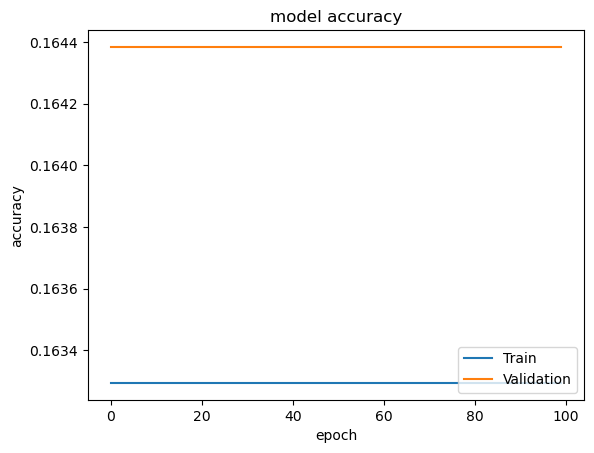

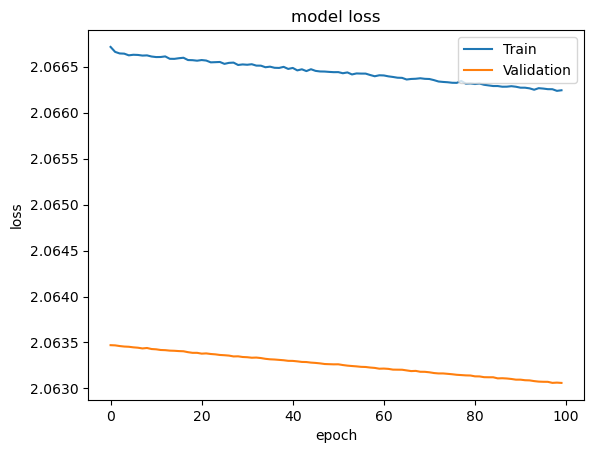

In [23]:
#accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

<h3>Classification report</h3>

In [24]:
predictions = model.predict(test, verbose=0)
# predictions = predictions.reshape(1,-1)[0]
lst = np.argmax(predictions, axis= 1)

print(classification_report(test.classes, lst, target_names = test.class_indices))

              precision    recall  f1-score   support

    Duracell       0.16      1.00      0.27        14
   Energizer       0.00      0.00      0.00        14
    Eveready       0.00      0.00      0.00        10
       Exell       0.00      0.00      0.00         9
          GP       0.00      0.00      0.00        12
        Ikea       0.00      0.00      0.00         9
      Klarus       0.00      0.00      0.00        11
   Panasonic       0.00      0.00      0.00        10

    accuracy                           0.16        89
   macro avg       0.02      0.12      0.03        89
weighted avg       0.02      0.16      0.04        89



c:\Users\ngden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ngden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ngden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h3>Confusion matrix</h3>

[[14  0  0  0  0  0  0  0]
 [14  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0]
 [12  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0]
 [11  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0]]


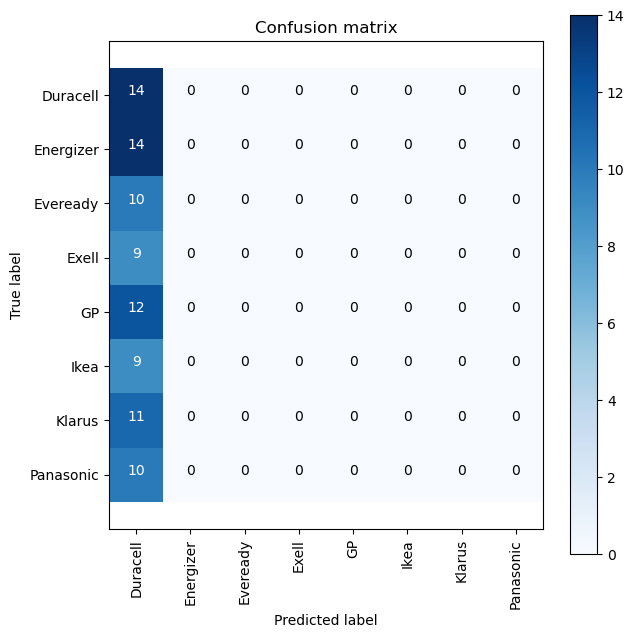

In [25]:
result = confusion_matrix(test.classes, lst)
print(result)

def plot_confusion_matrix(result, classes, cmap=plt.cm.Blues):
    plt.subplots(figsize=(7, 7))
    plt.imshow(result, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

    thresh = result.max() / 2.
    for i, j in itertools.product(range(result.shape[0]), range(result.shape[1])):
        plt.text(j, i, result[i, j],
            horizontalalignment="center",
            color = "white" if result[i, j] > thresh else "black")
        
    #current matplotlib version will cut off top and bottom of the matrix, 
    #hence the manual workaround - remove if matplotlib version does not cut off
    b, t = plt.ylim() # discover bottom and top values
    b += 0.5 # Add 0.5 to bottom
    t -= 0.5 # Subtract 0.5 from top
    plt.ylim(b, t) # update ylim(bottom, top) values
    plt.show()
    
plot_confusion_matrix(result, list(test.class_indices.keys()))

<h3>Labels of wrong predictions</h3>

In [27]:
def getErrors(test, predictions):
    #get file names of all images in test data
    names = test.filenames

    #get IDs of all classes
    allClassesID = test.classes

    #get dictionary of classes and respective ID
    classLabelDict = test.class_indices
    
    #list of the names of all classes
    classLabels = list(classLabelDict.keys())

    print("The list of classes: ", classLabels)

    #get the most predicted class
    predictedClasses = np.argmax(predictions, axis=1)

    predictedErrors = np.where(predictedClasses != allClassesID)[0]

    print("Number of errors = {}/{}".format(len(predictedErrors),test.samples))

    return classLabels, predictedErrors, names

def showErrors(classLabels, predictedErrors, predictions, names):
    # Show the errors
    for i in range(len(errors)):
        predictedClass = np.argmax(predictions[predictedErrors[i]])

        predictedLabel = classLabels[predictedClass]

        title = 'Original Picture : {}, Prediction : {}, Confidence/Percentage : {:.3f}'.format\
                (names[predictedErrors[i]].split('/')[0],predictedLabel, predictions[errors[i]][predictedClass])
        print(title)

In [28]:
#get the list of class labels, prediction errors and file names
labels, errors, names = getErrors(test, predictions)

#show wrongly predicted images, prediction and and the percentage (confidence)
showErrors(labels, errors, predictions, names)

The list of classes:  ['Duracell', 'Energizer', 'Eveready', 'Exell', 'GP', 'Ikea', 'Klarus', 'Panasonic']
Number of errors = 75/89
Original Picture : Energizer\13.jpeg, Prediction : Duracell, Confidence/Percentage : 0.185
Original Picture : Energizer\21.jpg, Prediction : Duracell, Confidence/Percentage : 0.185
Original Picture : Energizer\25.jpg, Prediction : Duracell, Confidence/Percentage : 0.185
Original Picture : Energizer\5.jpeg, Prediction : Duracell, Confidence/Percentage : 0.185
Original Picture : Energizer\9 (2).jpeg, Prediction : Duracell, Confidence/Percentage : 0.185
Original Picture : Energizer\Alkaline-24.jpg, Prediction : Duracell, Confidence/Percentage : 0.185
Original Picture : Energizer\EnergizerAAA.jpg, Prediction : Duracell, Confidence/Percentage : 0.185
Original Picture : Energizer\Image_15.jpg, Prediction : Duracell, Confidence/Percentage : 0.185
Original Picture : Energizer\Image_27.jpg, Prediction : Duracell, Confidence/Percentage : 0.185
Original Picture : Ener

<h3>Save the model</h3>

In [ ]:
#change the directory back to initial path (Image Classification folder)
os.chdir("../..")
# os.listdir()

#save the model so that it can be passed to edge device
model.save("image_classification.h5")